In [1]:
# import argparse

class HParams(object):
	def __init__(self):
		# Dataset Settings
		self.dataset_path = 'd:/다운로드/gtzan'
		self.feature_path = 'feature2'
		self.genres = ['classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae']

		# Feature Parameters
		self.sample_rate = 22050
		self.fft_size = 1024
		self.win_size = 1024
		self.hop_size = 512
		self.num_mels = 128
		self.feature_length = 1024  # audio length = feature_length*hop_size/sample_rate (s)

		# Training Parameters
		self.device = 1  # 0: CPU, 1: GPU0, 2: GPU1, ...
		self.batch_size = 20
		self.num_epochs = 100
		self.learning_rate = 3*1e-5
		self.stopping_rate = 1e-12
		self.weight_decay = 1e-6
		self.momentum = 0.9
		self.factor = 0.2
		self.patience = 3.

hparams = HParams()

In [2]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader

class GTZANDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

# Function to get genre index for the give file
def get_label(file_name, hparams):
    genre = file_name.split('.')[0]
    label = hparams.genres.index(genre)
    return label

def load_dataset(set_name, hparams):
    x = []
    y = []

    dataset_path = os.path.join(hparams.feature_path, set_name)
    for root,dirs,files in os.walk(dataset_path):
        for file in files:
            data = np.load(os.path.join(root,file))
            label = get_label(file, hparams)
            x.append(data)
            y.append(label)

    x = np.stack(x)
    y = np.stack(y)

    return x,y

def get_dataloader(hparams):
    x_train, y_train = load_dataset('train', hparams)
    x_valid, y_valid = load_dataset('valid', hparams)
    x_test, y_test = load_dataset('test', hparams)

    mean = np.mean(x_train)
    std = np.std(x_train)
    x_train = (x_train - mean)/std
    x_valid = (x_valid - mean)/std
    x_test = (x_test - mean)/std

    train_set = GTZANDataset(x_train, y_train)
    vaild_set = GTZANDataset(x_valid, y_valid)
    test_set = GTZANDataset(x_test, y_test)

    train_loader = DataLoader(train_set, batch_size=hparams.batch_size, shuffle=True, drop_last=False)
    valid_loader = DataLoader(vaild_set, batch_size=hparams.batch_size, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_set, batch_size=hparams.batch_size, shuffle=False, drop_last=False)

    return train_loader, valid_loader, test_loader

In [3]:
from matplotlib import pyplot as plt

In [4]:
'''
train_test.py
A file for training model for genre classification.
Please check the device in hparams.py before you run this code.
'''
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

# import data_manager
# import models
# from hparams import hparams

# Wrapper class to run PyTorch model
class Runner(object):
    def __init__(self, hparams):
        self.model = Baseline(hparams)
        self.criterion = nn.CrossEntropyLoss()
        
        #self.optimizer = torch.optim.Adam(self.model.parameters(), lr=hparams.learning_rate)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=hparams.learning_rate, momentum=hparams.momentum)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=hparams.factor, patience=hparams.patience, verbose=True)
        self.learning_rate = hparams.learning_rate
        self.stopping_rate = hparams.stopping_rate
        self.device = torch.device("cpu")

        if hparams.device > 0:
            torch.cuda.set_device(hparams.device - 1)##
            self.model.cuda(hparams.device - 1)
            self.criterion.cuda(hparams.device - 1)
            self.device = torch.device("cuda:" + str(hparams.device - 1))
            
#         device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#         self.model = Baseline(hparams).to(device)
#         if torch.cuda.device_count() > 1:
#             print('\n===> Training on GPU!')
#             self.model = nn.DataParallel(net)

    # Accuracy function works like loss function in PyTorch
    def accuracy(self, source, target):
        source = source.max(1)[1].long().cpu()
        target = target.cpu()
        correct = (source == target).sum().item()

        return correct/float(source.size(0))

    # Running model for train, test and validation. mode: 'train' for training, 'eval' for validation and test
    def run(self, dataloader, mode='train'):
        self.model.train() if mode is 'train' else self.model.eval()

        epoch_loss = 0.0
        epoch_acc = 0.0
        
        for batch, (x, y) in enumerate(dataloader):
            x = x.to(self.device)
            y = y.to(self.device).type(torch.long)
            
            #print(y)

            prediction = self.model(x)
            loss = self.criterion(prediction, y)
            acc = self.accuracy(prediction, y)

            if mode is 'train':
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

            epoch_loss += prediction.size(0)*loss.item()
            epoch_acc += prediction.size(0)*acc

        epoch_loss = epoch_loss/len(dataloader.dataset)
        epoch_acc = epoch_acc/len(dataloader.dataset)

        return epoch_loss, epoch_acc

    # Early stopping function for given validation loss
    def early_stop(self, loss, epoch):
        self.scheduler.step(loss, epoch)
        self.learning_rate = self.optimizer.param_groups[0]['lr']
        stop = self.learning_rate < self.stopping_rate

        return stop

def device_name(device):
    if device == 0:
        device_name = 'CPU'
    else:
        device_name = 'GPU:' + str(device - 1)

    return device_name

def main():  
    train_loader, valid_loader, test_loader = get_dataloader(hparams)
    runner = Runner(hparams)
    val_loss_ls =[]
    train_loss_ls =[]

    print('Training on ' + device_name(hparams.device))
    for epoch in range(hparams.num_epochs):
        train_loss, train_acc = runner.run(train_loader, 'train')
        valid_loss, valid_acc = runner.run(valid_loader, 'eval')
        if((epoch+1)%10==0):
            print("[Epoch %d/%d] [Train Loss: %.4f] [Train Acc: %.4f] [Valid Loss: %.4f] [Valid Acc: %.4f]" %
                  (epoch + 1, hparams.num_epochs, train_loss, train_acc, valid_loss, valid_acc))
            
        val_loss_ls.append(valid_loss)
        train_loss_ls.append(train_loss)
        
        if runner.early_stop(valid_loss, epoch + 1):
            break

    test_loss, test_acc = runner.run(test_loader, 'eval')
    print("Training Finished")
    print("Test Accuracy: %.2f%%" % (100*test_acc))
    
    plt.plot(val_loss_ls,'r')
    plt.plot(train_loss_ls,'b')
    plt.show()
    

In [5]:
'''
CNN 계층 증가
Dropout 추가 1, 6
'''
import torch.nn as nn

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        self._initialize_weights()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        
        
        self.conv4 = nn.Sequential(
        nn.Conv1d(128, 96, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(96),
        nn.ReLU(),
        nn.MaxPool1d(6, stride=6)
        )

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(96, 117),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)+x1 #Resnet1
        x = torch.cat((self.conv2_1(x)+self.conv2_2(x),self.conv2_2(x)+self.conv2_1(x)),2)
        x = self.conv3(x)
        x = x+x2#Resnet 2  
        x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fand_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias,0.8)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0.8)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias,0.8)

In [ ]:
main()

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.9137] [Train Acc: 0.3133] [Valid Loss: 1.9728] [Valid Acc: 0.2562]
[Epoch 20/100] [Train Loss: 1.8139] [Train Acc: 0.5078] [Valid Loss: 1.9116] [Valid Acc: 0.3563]
[Epoch 30/100] [Train Loss: 1.7266] [Train Acc: 0.5969] [Valid Loss: 1.8385] [Valid Acc: 0.4562]


In [6]:
hparams.learning_rate = 5*1e-6
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 3.

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.9532] [Train Acc: 0.3471] [Valid Loss: 1.9878] [Valid Acc: 0.3600]
[Epoch 20/100] [Train Loss: 1.8624] [Train Acc: 0.4292] [Valid Loss: 1.9213] [Valid Acc: 0.3467]
[Epoch 30/100] [Train Loss: 1.7711] [Train Acc: 0.4691] [Valid Loss: 1.8433] [Valid Acc: 0.4133]
[Epoch 40/100] [Train Loss: 1.6739] [Train Acc: 0.5054] [Valid Loss: 1.7615] [Valid Acc: 0.4000]
[Epoch 50/100] [Train Loss: 1.5780] [Train Acc: 0.5405] [Valid Loss: 1.6970] [Valid Acc: 0.3933]
[Epoch 60/100] [Train Loss: 1.4776] [Train Acc: 0.5757] [Valid Loss: 1.6104] [Valid Acc: 0.4333]
[Epoch 70/100] [Train Loss: 1.3811] [Train Acc: 0.6052] [Valid Loss: 1.5010] [Valid Acc: 0.4867]
[Epoch 80/100] [Train Loss: 1.2909] [Train Acc: 0.6373] [Valid Loss: 1.4129] [Valid Acc: 0.5200]
[Epoch 90/100] [Train Loss: 1.1918] [Train Acc: 0.6753] [Valid Loss: 1.3450] [Valid Acc: 0.5667]
[Epoch 100/100] [Train Loss: 1.1075] [Train Acc: 0.7038] [Valid Loss: 1.2881] [Valid Acc: 0.5533]
Training Fi

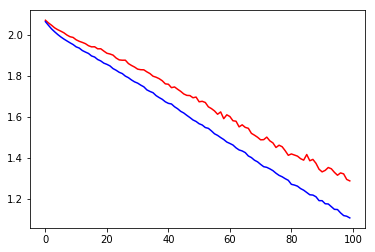

In [7]:
main()

In [8]:
hparams.learning_rate = 1e-5
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 3.

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.8255] [Train Acc: 0.4133] [Valid Loss: 1.8382] [Valid Acc: 0.4400]
[Epoch 20/100] [Train Loss: 1.6041] [Train Acc: 0.5565] [Valid Loss: 1.6125] [Valid Acc: 0.5333]
[Epoch 30/100] [Train Loss: 1.3700] [Train Acc: 0.6495] [Valid Loss: 1.4140] [Valid Acc: 0.5533]
[Epoch 40/100] [Train Loss: 1.1428] [Train Acc: 0.7235] [Valid Loss: 1.2703] [Valid Acc: 0.5867]
[Epoch 50/100] [Train Loss: 0.9297] [Train Acc: 0.7876] [Valid Loss: 1.1478] [Valid Acc: 0.6200]
[Epoch 60/100] [Train Loss: 0.7576] [Train Acc: 0.8281] [Valid Loss: 1.0430] [Valid Acc: 0.6533]
[Epoch 70/100] [Train Loss: 0.6155] [Train Acc: 0.8656] [Valid Loss: 0.9958] [Valid Acc: 0.6800]
Epoch    71: reducing learning rate of group 0 to 2.0000e-06.
Epoch    79: reducing learning rate of group 0 to 4.0000e-07.
[Epoch 80/100] [Train Loss: 0.5749] [Train Acc: 0.8749] [Valid Loss: 0.9926] [Valid Acc: 0.6867]
Epoch    86: reducing learning rate of group 0 to 8.0000e-08.
[Epoch 90/100] [Trai

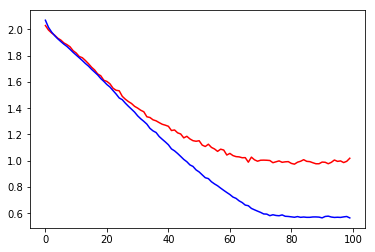

In [9]:
main()

In [10]:
hparams.learning_rate = 1e-4
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 3.

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.4637] [Train Acc: 0.8998] [Valid Loss: 0.9249] [Valid Acc: 0.6733]
[Epoch 20/100] [Train Loss: 0.1377] [Train Acc: 0.9720] [Valid Loss: 0.9495] [Valid Acc: 0.6867]
Epoch    21: reducing learning rate of group 0 to 2.0000e-05.
Epoch    25: reducing learning rate of group 0 to 4.0000e-06.
Epoch    29: reducing learning rate of group 0 to 8.0000e-07.
[Epoch 30/100] [Train Loss: 0.0918] [Train Acc: 0.9865] [Valid Loss: 0.8878] [Valid Acc: 0.7200]
Epoch    33: reducing learning rate of group 0 to 1.6000e-07.
Epoch    37: reducing learning rate of group 0 to 3.2000e-08.
[Epoch 40/100] [Train Loss: 0.0876] [Train Acc: 0.9858] [Valid Loss: 0.9096] [Valid Acc: 0.6933]
Epoch    41: reducing learning rate of group 0 to 6.4000e-09.
[Epoch 50/100] [Train Loss: 0.0935] [Train Acc: 0.9839] [Valid Loss: 0.8887] [Valid Acc: 0.6933]
[Epoch 60/100] [Train Loss: 0.0938] [Train Acc: 0.9844] [Valid Loss: 0.8929] [Valid Acc: 0.7000]
[Epoch 70/100] [Train Loss: 

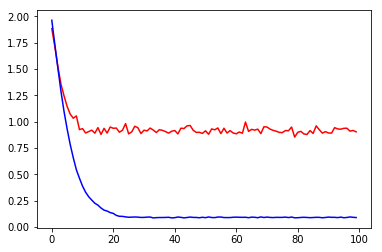

In [11]:
main()

In [6]:
hparams.learning_rate = 5*1e-5
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 3.

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.0377] [Train Acc: 0.7294] [Valid Loss: 1.2601] [Valid Acc: 0.5067]
Epoch    15: reducing learning rate of group 0 to 1.0000e-05.
[Epoch 20/100] [Train Loss: 0.5664] [Train Acc: 0.8726] [Valid Loss: 1.1978] [Valid Acc: 0.5267]
Epoch    27: reducing learning rate of group 0 to 2.0000e-06.
[Epoch 30/100] [Train Loss: 0.4865] [Train Acc: 0.8979] [Valid Loss: 1.2002] [Valid Acc: 0.5400]
Epoch    35: reducing learning rate of group 0 to 4.0000e-07.
Epoch    39: reducing learning rate of group 0 to 8.0000e-08.
[Epoch 40/100] [Train Loss: 0.4743] [Train Acc: 0.8960] [Valid Loss: 1.1605] [Valid Acc: 0.5533]
Epoch    43: reducing learning rate of group 0 to 1.6000e-08.
Epoch    47: reducing learning rate of group 0 to 3.2000e-09.
[Epoch 50/100] [Train Loss: 0.4820] [Train Acc: 0.8946] [Valid Loss: 1.1734] [Valid Acc: 0.5600]
[Epoch 60/100] [Train Loss: 0.4791] [Train Acc: 0.8988] [Valid Loss: 1.1229] [Valid Acc: 0.5667]
[Epoch 70/100] [Train Loss: 

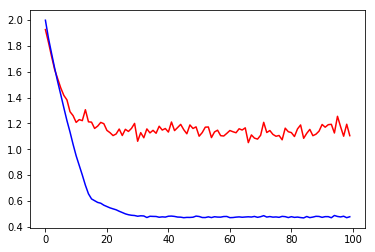

In [7]:
main()

In [6]:
# import argparse

hparams.batch_size = 20
hparams.num_epochs = 100
hparams.learning_rate = 5*1e-5

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.1178] [Train Acc: 0.6949] [Valid Loss: 1.2811] [Valid Acc: 0.5133]
[Epoch 20/100] [Train Loss: 0.4886] [Train Acc: 0.8907] [Valid Loss: 0.9370] [Valid Acc: 0.7000]
Epoch    27: reducing learning rate of group 0 to 1.0000e-05.
[Epoch 30/100] [Train Loss: 0.2633] [Train Acc: 0.9474] [Valid Loss: 0.9520] [Valid Acc: 0.6733]
Epoch    32: reducing learning rate of group 0 to 2.0000e-06.
Epoch    36: reducing learning rate of group 0 to 4.0000e-07.
[Epoch 40/100] [Train Loss: 0.2537] [Train Acc: 0.9486] [Valid Loss: 0.8897] [Valid Acc: 0.7000]
Epoch    44: reducing learning rate of group 0 to 8.0000e-08.
Epoch    48: reducing learning rate of group 0 to 1.6000e-08.
[Epoch 50/100] [Train Loss: 0.2534] [Train Acc: 0.9489] [Valid Loss: 0.9585] [Valid Acc: 0.6800]
Epoch    52: reducing learning rate of group 0 to 3.2000e-09.
[Epoch 60/100] [Train Loss: 0.2455] [Train Acc: 0.9520] [Valid Loss: 0.9428] [Valid Acc: 0.6933]
[Epoch 70/100] [Train Loss: 

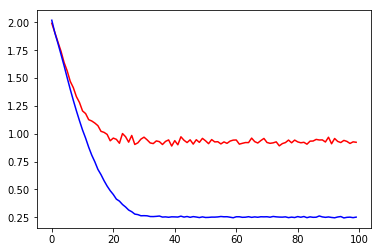

In [7]:
main()

In [6]:
hparams.learning_rate = 3*1e-5

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.4137] [Train Acc: 0.5904] [Valid Loss: 1.5293] [Valid Acc: 0.4067]
[Epoch 20/100] [Train Loss: 0.8522] [Train Acc: 0.7895] [Valid Loss: 1.2194] [Valid Acc: 0.5267]
[Epoch 30/100] [Train Loss: 0.4590] [Train Acc: 0.9063] [Valid Loss: 1.0834] [Valid Acc: 0.6133]
Epoch    31: reducing learning rate of group 0 to 6.0000e-06.
Epoch    38: reducing learning rate of group 0 to 1.2000e-06.
[Epoch 40/100] [Train Loss: 0.3874] [Train Acc: 0.9208] [Valid Loss: 1.0956] [Valid Acc: 0.5933]
Epoch    43: reducing learning rate of group 0 to 2.4000e-07.
Epoch    47: reducing learning rate of group 0 to 4.8000e-08.
[Epoch 50/100] [Train Loss: 0.3734] [Train Acc: 0.9306] [Valid Loss: 1.0116] [Valid Acc: 0.6333]
Epoch    53: reducing learning rate of group 0 to 9.6000e-09.
[Epoch 60/100] [Train Loss: 0.3782] [Train Acc: 0.9280] [Valid Loss: 1.0452] [Valid Acc: 0.6200]
[Epoch 70/100] [Train Loss: 0.3815] [Train Acc: 0.9270] [Valid Loss: 1.0508] [Valid Acc: 0

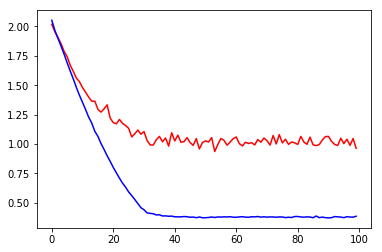

In [7]:
main()

In [6]:
hparams.learning_rate = 2*1e-5

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.6672] [Train Acc: 0.5365] [Valid Loss: 1.7106] [Valid Acc: 0.4467]
[Epoch 20/100] [Train Loss: 1.2661] [Train Acc: 0.6584] [Valid Loss: 1.3942] [Valid Acc: 0.4867]
[Epoch 30/100] [Train Loss: 0.9171] [Train Acc: 0.7769] [Valid Loss: 1.2001] [Valid Acc: 0.5800]
[Epoch 40/100] [Train Loss: 0.6180] [Train Acc: 0.8652] [Valid Loss: 1.0707] [Valid Acc: 0.6600]
Epoch    43: reducing learning rate of group 0 to 4.0000e-06.
[Epoch 50/100] [Train Loss: 0.5143] [Train Acc: 0.8927] [Valid Loss: 1.0503] [Valid Acc: 0.6467]
Epoch    50: reducing learning rate of group 0 to 8.0000e-07.
Epoch    54: reducing learning rate of group 0 to 1.6000e-07.
Epoch    58: reducing learning rate of group 0 to 3.2000e-08.
[Epoch 60/100] [Train Loss: 0.5021] [Train Acc: 0.8958] [Valid Loss: 1.0383] [Valid Acc: 0.6533]
Epoch    62: reducing learning rate of group 0 to 6.4000e-09.
[Epoch 70/100] [Train Loss: 0.5109] [Train Acc: 0.8907] [Valid Loss: 1.0462] [Valid Acc: 0

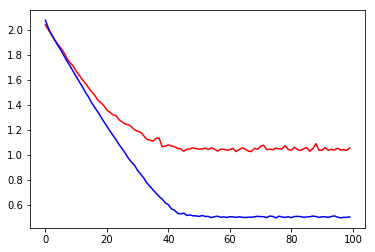

In [7]:
main()

In [6]:
hparams.learning_rate = 1e-5

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.7996] [Train Acc: 0.4467] [Valid Loss: 1.8334] [Valid Acc: 0.3933]
[Epoch 20/100] [Train Loss: 1.5834] [Train Acc: 0.5244] [Valid Loss: 1.6455] [Valid Acc: 0.4067]
[Epoch 30/100] [Train Loss: 1.3871] [Train Acc: 0.5938] [Valid Loss: 1.4728] [Valid Acc: 0.4667]
[Epoch 40/100] [Train Loss: 1.2030] [Train Acc: 0.6636] [Valid Loss: 1.3383] [Valid Acc: 0.5333]
[Epoch 50/100] [Train Loss: 1.0209] [Train Acc: 0.7399] [Valid Loss: 1.2515] [Valid Acc: 0.5400]
[Epoch 60/100] [Train Loss: 0.8494] [Train Acc: 0.7948] [Valid Loss: 1.1590] [Valid Acc: 0.6133]
[Epoch 70/100] [Train Loss: 0.7091] [Train Acc: 0.8356] [Valid Loss: 1.1007] [Valid Acc: 0.6133]
Epoch    76: reducing learning rate of group 0 to 2.0000e-06.
[Epoch 80/100] [Train Loss: 0.6119] [Train Acc: 0.8675] [Valid Loss: 1.0743] [Valid Acc: 0.6333]
Epoch    81: reducing learning rate of group 0 to 4.0000e-07.
Epoch    85: reducing learning rate of group 0 to 8.0000e-08.
Epoch    89: reducin

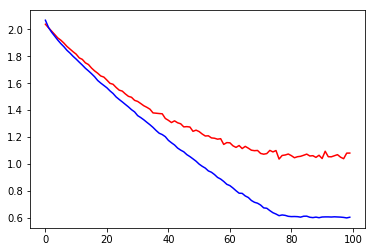

In [7]:
main()

In [7]:
hparams.learning_rate = 3*1e-5
hparams.momentum = 0.9

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.5192] [Train Acc: 0.5078] [Valid Loss: 1.5490] [Valid Acc: 0.4067]
[Epoch 20/100] [Train Loss: 1.0255] [Train Acc: 0.7257] [Valid Loss: 1.1943] [Valid Acc: 0.5600]
[Epoch 30/100] [Train Loss: 0.6199] [Train Acc: 0.8558] [Valid Loss: 1.0516] [Valid Acc: 0.6800]
[Epoch 40/100] [Train Loss: 0.3789] [Train Acc: 0.9176] [Valid Loss: 0.8910] [Valid Acc: 0.7333]
Epoch    44: reducing learning rate of group 0 to 6.0000e-06.
Epoch    48: reducing learning rate of group 0 to 1.2000e-06.
[Epoch 50/100] [Train Loss: 0.2864] [Train Acc: 0.9422] [Valid Loss: 0.9483] [Valid Acc: 0.7067]
Epoch    52: reducing learning rate of group 0 to 2.4000e-07.
Epoch    56: reducing learning rate of group 0 to 4.8000e-08.
[Epoch 60/100] [Train Loss: 0.2879] [Train Acc: 0.9426] [Valid Loss: 0.9248] [Valid Acc: 0.7067]
Epoch    60: reducing learning rate of group 0 to 9.6000e-09.
[Epoch 70/100] [Train Loss: 0.2921] [Train Acc: 0.9427] [Valid Loss: 0.8935] [Valid Acc: 0

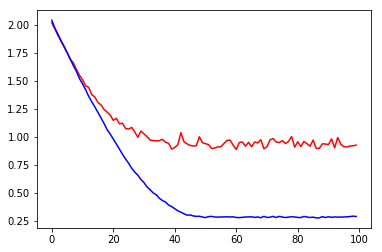

In [8]:
main()

In [9]:
hparams.num_epochs = 100
hparams.batch_size = 30
hparams.learning_rate = 8*1e-5
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 2.5

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.0383] [Train Acc: 0.7430] [Valid Loss: 1.2495] [Valid Acc: 0.5667]
[Epoch 20/100] [Train Loss: 0.3812] [Train Acc: 0.9223] [Valid Loss: 0.9413] [Valid Acc: 0.6867]
Epoch    29: reducing learning rate of group 0 to 1.6000e-05.
[Epoch 30/100] [Train Loss: 0.1771] [Train Acc: 0.9673] [Valid Loss: 0.8850] [Valid Acc: 0.7467]
Epoch    33: reducing learning rate of group 0 to 3.2000e-06.
Epoch    36: reducing learning rate of group 0 to 6.4000e-07.
Epoch    39: reducing learning rate of group 0 to 1.2800e-07.
[Epoch 40/100] [Train Loss: 0.1618] [Train Acc: 0.9745] [Valid Loss: 0.9634] [Valid Acc: 0.6933]
Epoch    42: reducing learning rate of group 0 to 2.5600e-08.
Epoch    45: reducing learning rate of group 0 to 5.1200e-09.
[Epoch 50/100] [Train Loss: 0.1569] [Train Acc: 0.9752] [Valid Loss: 0.9208] [Valid Acc: 0.7267]
[Epoch 60/100] [Train Loss: 0.1622] [Train Acc: 0.9735] [Valid Loss: 0.9215] [Valid Acc: 0.7133]
[Epoch 70/100] [Train Loss: 

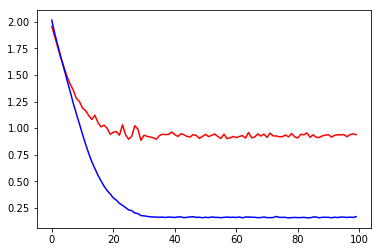

In [10]:
main()

In [11]:
hparams.learning_rate = 5*1e-5
hparams.patience = 3.

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.4326] [Train Acc: 0.5788] [Valid Loss: 1.4956] [Valid Acc: 0.4267]
[Epoch 20/100] [Train Loss: 0.8546] [Train Acc: 0.7970] [Valid Loss: 1.1799] [Valid Acc: 0.5533]
[Epoch 30/100] [Train Loss: 0.4733] [Train Acc: 0.8975] [Valid Loss: 1.0480] [Valid Acc: 0.6200]
[Epoch 40/100] [Train Loss: 0.2746] [Train Acc: 0.9428] [Valid Loss: 0.9622] [Valid Acc: 0.6533]
Epoch    40: reducing learning rate of group 0 to 1.0000e-05.
Epoch    44: reducing learning rate of group 0 to 2.0000e-06.
Epoch    48: reducing learning rate of group 0 to 4.0000e-07.
[Epoch 50/100] [Train Loss: 0.2492] [Train Acc: 0.9534] [Valid Loss: 0.9653] [Valid Acc: 0.6533]
Epoch    53: reducing learning rate of group 0 to 8.0000e-08.
Epoch    57: reducing learning rate of group 0 to 1.6000e-08.
[Epoch 60/100] [Train Loss: 0.2513] [Train Acc: 0.9516] [Valid Loss: 1.0194] [Valid Acc: 0.6533]
Epoch    61: reducing learning rate of group 0 to 3.2000e-09.
[Epoch 70/100] [Train Loss: 

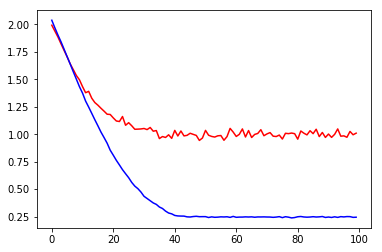

In [12]:
main()

In [13]:

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(128*14, 117),
        nn.Dropout(p=0.4, inplace=False),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)+x1 #Resnet1
        x = self.conv2_2(x)
        #x = self.conv3(x)
        #x = x+x2#Resnet 2  
        #x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.2380] [Train Acc: 0.6019] [Valid Loss: 1.3025] [Valid Acc: 0.5133]
[Epoch 20/100] [Train Loss: 0.7541] [Train Acc: 0.7717] [Valid Loss: 0.9977] [Valid Acc: 0.6600]
Epoch    28: reducing learning rate of group 0 to 1.0000e-05.
[Epoch 30/100] [Train Loss: 0.4723] [Train Acc: 0.8662] [Valid Loss: 0.8814] [Valid Acc: 0.6867]
Epoch    34: reducing learning rate of group 0 to 2.0000e-06.
Epoch    38: reducing learning rate of group 0 to 4.0000e-07.
[Epoch 40/100] [Train Loss: 0.4372] [Train Acc: 0.8798] [Valid Loss: 0.9052] [Valid Acc: 0.6800]
Epoch    42: reducing learning rate of group 0 to 8.0000e-08.
Epoch    46: reducing learning rate of group 0 to 1.6000e-08.
[Epoch 50/100] [Train Loss: 0.4354] [Train Acc: 0.8812] [Valid Loss: 0.9089] [Valid Acc: 0.6867]
Epoch    50: reducing learning rate of group 0 to 3.2000e-09.
[Epoch 60/100] [Train Loss: 0.4340] [Train Acc: 0.8811] [Valid Loss: 0.9028] [Valid Acc: 0.7000]
[Epoch 70/100] [Train Loss: 

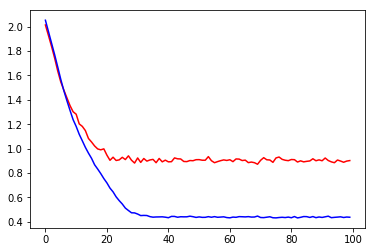

In [14]:
main()

In [15]:

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(128*14, 117),
        nn.Dropout(p=0.4, inplace=False),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)
        x = self.conv2_2(x)
        #x = self.conv3(x)
        #x = x+x2#Resnet 2  
        #x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.2282] [Train Acc: 0.5890] [Valid Loss: 1.4077] [Valid Acc: 0.4333]
[Epoch 20/100] [Train Loss: 0.7534] [Train Acc: 0.7637] [Valid Loss: 1.2935] [Valid Acc: 0.4600]
Epoch    21: reducing learning rate of group 0 to 1.0000e-05.
Epoch    27: reducing learning rate of group 0 to 2.0000e-06.
[Epoch 30/100] [Train Loss: 0.6362] [Train Acc: 0.8140] [Valid Loss: 1.2854] [Valid Acc: 0.4733]
Epoch    31: reducing learning rate of group 0 to 4.0000e-07.
Epoch    35: reducing learning rate of group 0 to 8.0000e-08.
Epoch    39: reducing learning rate of group 0 to 1.6000e-08.
[Epoch 40/100] [Train Loss: 0.6257] [Train Acc: 0.8178] [Valid Loss: 1.2685] [Valid Acc: 0.4800]
Epoch    43: reducing learning rate of group 0 to 3.2000e-09.
[Epoch 50/100] [Train Loss: 0.6305] [Train Acc: 0.8145] [Valid Loss: 1.2161] [Valid Acc: 0.5200]
[Epoch 60/100] [Train Loss: 0.6320] [Train Acc: 0.8140] [Valid Loss: 1.3100] [Valid Acc: 0.4533]
[Epoch 70/100] [Train Loss: 

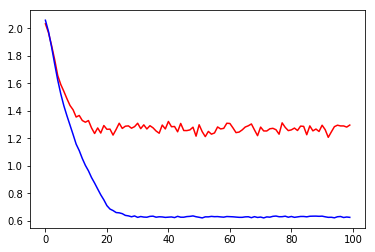

In [16]:
main()

In [6]:
main()

MemoryError: 

In [17]:
hparams.num_epochs = 100
hparams.batch_size = 30
hparams.learning_rate = 1e-5
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 3.

In [18]:
main()

MemoryError: 

In [19]:
hparams.num_epochs = 100
hparams.batch_size = 40
hparams.learning_rate = 2*1e-5
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 3.

In [20]:
main()

MemoryError: 

In [ ]:
hparams.num_epochs = 100
hparams.batch_size = 10
hparams.learning_rate = 4*1e-5
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 3.

In [ ]:
main()

In [ ]:

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(128*14, 117),
        nn.Dropout(p=0.4, inplace=False),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)
        x = self.conv2_1(x)
        #x = self.conv3(x)
        #x = x+x2#Resnet 2  
        #x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    

In [ ]:
main()